<a href="https://colab.research.google.com/github/akuma527/IProjects/blob/master/I%26D_Whale/Data_Preprocessing_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive/Colab Notebooks/I&D_Whale/data/

/content/drive/My Drive/Colab Notebooks/I&D_Whale/data


In [22]:
!pip install tqdm -U

     |████████████████████████████████| 61kB 2.0MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [0]:
import pandas as pd
import os
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
%matplotlib inline
from tqdm.notebook import tqdm

In [0]:
train = pd.read_csv('train.csv')

In [0]:
img_array = cv2.imread(train['fil_path'].iloc[9], cv2.IMREAD_GRAYSCALE)

In [6]:
img_array.shape

(564, 936)

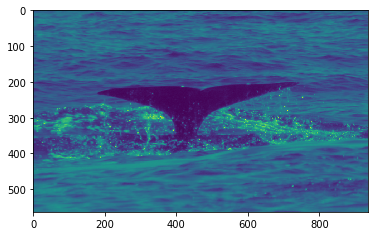

In [7]:
plt.imshow(img_array)

In [0]:
new_array = cv2.resize(img_array, (300, 300))

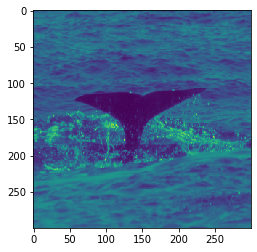

In [9]:
plt.imshow(new_array)

In [0]:
[i for i in train['fil_path'].head()]

['train/-1/PM-WWA-20050416-037.jpg',
 'train/-1/PM-WWA-20050513-229.jpg',
 'train/-1/PM-WWA-20050513-243.jpg',
 'train/-1/PM-WWA-20050520-134.jpg',
 'train/-1/PM-WWA-20050612-047.jpg']

## Converting Training Images into Pixels

In [10]:
os.listdir()

['test',
 'train',
 'pickled_obj',
 'test.csv',
 '.ipynb_checkpoints',
 'train.csv',
 'data_train.csv',
 'same_images.csv',
 'data_prep_fin.csv',
 'not_similar.csv',
 'final_train.csv']

In [0]:
t1 = pd.read_csv('final_train.csv')
t2 = pd.read_csv('not_similar.csv')
t1['sim'] = 1
t2['sim'] = 0

In [0]:
train = pd.concat([t1, t2], ignore_index=True, sort=False)

In [9]:
train.head()

,Image,Id,fil_path,Image_2,Id_2,fil_path_2,sim
0,PM-WWA-20050413-003b.jpg,2764,train/2764/PM-WWA-20050413-003b.jpg,PM-WWA-20050413-029.jpg,2764,train/2764/PM-WWA-20050413-029.jpg,1
1,PM-WWA-20050413-029.jpg,2764,train/2764/PM-WWA-20050413-029.jpg,PM-WWA-20050413-003b.jpg,2764,train/2764/PM-WWA-20050413-003b.jpg,1
2,PM-WWA-20050413-006.jpg,2825,train/2825/PM-WWA-20050413-006.jpg,PM-WWA-20050413-007.jpg,2825,train/2825/PM-WWA-20050413-007.jpg,1
3,PM-WWA-20050413-007.jpg,2825,train/2825/PM-WWA-20050413-007.jpg,PM-WWA-20050413-006.jpg,2825,train/2825/PM-WWA-20050413-006.jpg,1
4,PM-WWA-20050413-009.jpg,2826,train/2826/PM-WWA-20050413-009.jpg,PM-BIO-20050413-049.jpg,2826,train/2826/PM-BIO-20050413-049.jpg,1


In [10]:
train.tail()

,Image,Id,fil_path,Image_2,Id_2,fil_path_2,sim
15873,PM-WWA-20161013-285.jpg,5944,train/5944/PM-WWA-20161013-285.jpg,PM-WWA-20161013-300.jpg,5945,train/5945/PM-WWA-20161013-300.jpg,0
15874,PM-WWA-20161013-300.jpg,5945,train/5945/PM-WWA-20161013-300.jpg,PM-WWA-20161013-314.jpg,5946,train/5946/PM-WWA-20161013-314.jpg,0
15875,PM-WWA-20161013-314.jpg,5946,train/5946/PM-WWA-20161013-314.jpg,PM-WWA-20161013-351.jpg,5947,train/5947/PM-WWA-20161013-351.jpg,0
15876,PM-WWA-20161013-351.jpg,5947,train/5947/PM-WWA-20161013-351.jpg,PM-WWA-20161025-008.jpg,5948,train/5948/PM-WWA-20161025-008.jpg,0
15877,PM-WWA-20161025-008.jpg,5948,train/5948/PM-WWA-20161025-008.jpg,IMG_2270-16.jpg,1756,train/1756/IMG_2270-16.jpg,0


In [11]:
train['sim'].value_counts()/len(train)

1    0.895453
0    0.104547
Name: sim, dtype: float64

In [0]:
training_data = []

In [41]:
for i in tqdm(range(len(train))):
    s = train['fil_path'].iloc[i]
    ss = train['fil_path_2'].iloc[i]
    img_array_1 = cv2.imread(s, cv2.IMREAD_GRAYSCALE)
    img_array_2 = cv2.imread(ss, cv2.IMREAD_GRAYSCALE)
    new_array_1 = cv2.resize(img_array_1, (384, 384))
    new_array_2 = cv2.resize(img_array_2, (384, 384))
    lab = train['sim'].iloc[i]

    training_data.append([new_array_1, new_array_2, lab])

In [0]:
a,b,c = training_data[0]

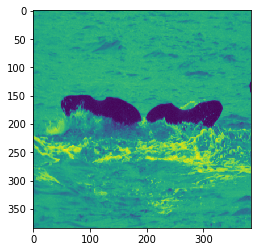

In [43]:
plt.imshow(a)

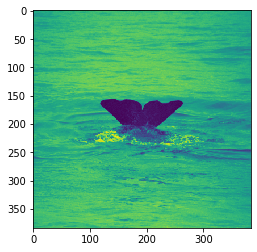

In [44]:
plt.imshow(b)

In [45]:
c

1

In [0]:
import pickle
with (open('training_data.obj', 'wb')) as fp:
    pickle.dump(training_data, fp)

In [47]:
os.listdir()

['test',
 'train',
 'pickled_obj',
 'test.csv',
 '.ipynb_checkpoints',
 'train.csv',
 'data_train.csv',
 'same_images.csv',
 'data_prep_fin.csv',
 'not_similar.csv',
 'final_train.csv',
 'training_data.obj']

# Training

In [0]:
from keras import regularizers
from keras.optimizers import Adam
from keras.engine.topology import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape
from keras.models import Model
from keras import backend as K

In [55]:
a.reshape(384,384,1).shape

(384, 384, 1)

In [0]:
img_shape = (384, 384, 3)

In [0]:
def subblock(x, filter, **kwargs):
    x = BatchNormalization()(x)
    y = x
    y = Conv2D(filter, (1, 1), activation='relu', **kwargs)(y) # Reduce the number of features to 'filter'
    y = BatchNormalization()(y)
    y = Conv2D(filter, (3, 3), activation='relu', **kwargs)(y) # Extend the feature field
    y = BatchNormalization()(y)
    y = Conv2D(K.int_shape(x)[-1], (1, 1), **kwargs)(y) # no activation # Restore the number of original features
    y = Add()([x,y]) # Add the bypass connection
    y = Activation('relu')(y)
    return y


In [0]:
def build_model(lr, l2, activation='sigmoid'):

    ##############
    # BRANCH MODEL
    ##############
    regul  = regularizers.l2(l2)
    optim  = Adam(lr=lr)
    kwargs = {'padding':'same', 'kernel_regularizer':regul}

    inp = Input(shape=img_shape) # 384x384x1
    x   = Conv2D(64, (9,9), strides=2, activation='relu', **kwargs)(inp)

    x   = MaxPooling2D((2, 2), strides=(2, 2))(x) # 96x96x64
    for _ in range(2):
        x = BatchNormalization()(x)
        x = Conv2D(64, (3,3), activation='relu', **kwargs)(x)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 48x48x64
    x = BatchNormalization()(x)
    x = Conv2D(128, (1,1), activation='relu', **kwargs)(x) # 48x48x128
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 24x24x128
    x = BatchNormalization()(x)
    x = Conv2D(256, (1,1), activation='relu', **kwargs)(x) # 24x24x256
    for _ in range(4): x = subblock(x, 64, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 12x12x256
    x = BatchNormalization()(x)
    x = Conv2D(384, (1,1), activation='relu', **kwargs)(x) # 12x12x384
    for _ in range(4): x = subblock(x, 96, **kwargs)

    x = MaxPooling2D((2, 2), strides=(2, 2))(x) # 6x6x384
    x = BatchNormalization()(x)
    x = Conv2D(512, (1,1), activation='relu', **kwargs)(x) # 6x6x512
    for _ in range(4): x = subblock(x, 128, **kwargs)
    
    x             = GlobalMaxPooling2D()(x) # 512
    branch_model  = Model(inp, x)
    # ------X------X------X------X-------#
    
    ############
    # HEAD MODEL
    ############
    mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])
    x1         = Lambda(lambda x : x[0]*x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : x[0] + x[1])([xa_inp, xb_inp])
    x3         = Lambda(lambda x : K.abs(x[0] - x[1]))([xa_inp, xb_inp])
    x4         = Lambda(lambda x : K.square(x))(x3)
    x          = Concatenate()([x1, x2, x3, x4])
    x          = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x          = Conv2D(mid, (4, 1), activation='relu', padding='valid')(x)
    x          = Reshape((branch_model.output_shape[1], mid, 1))(x)
    x          = Conv2D(1, (1, mid), activation='linear', padding='valid')(x)
    x          = Flatten(name='flatten')(x)
    
    # Weighted sum implemented as a Dense layer.
    x          = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')
    # ------X------X------X------X-------#

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    x          = head_model([xa, xb])
    model      = Model([img_a, img_b], x)
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model
    # ------X------X------X------X-------#

In [62]:
model, branch_model, head_model = build_model(64e-5,0)
head_model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 512)          0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________